# Project 2 - Classification and regression using Neural Networks

This notebook contains the code which produces all results for the Project 2 report in FYS-STK4155.

*Fall 2025*

**Authors:** Jenny Guldvog, Ingvild Olden Bjerklund, Sverre Manu Johansen & Kjersti Stangeland

### Import packages, and prep train and test data:

In [1]:
import sys, os
from pathlib import Path
import matplotlib.pyplot as plt
import time
import autograd.numpy as np
import numpy as np
from autograd import grad, elementwise_grad
from typing import Tuple, List
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error
from keras.optimizers import SGD, Adam     # NB! Remember this definition !!

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from functions import *
from functions.ffnn_lib_funcs import FFNN, scikitFFNN, kerasFFNN, pytorchFFNN

%load_ext autoreload
%autoreload 2

In [2]:
# For plotting

import matplotlib.style as mplstyle

mplstyle.use(["ggplot", "fast"])

# plt.rcParams.update({
#     'font.size': 16,          
#     'axes.titlesize': 18,     
#     'axes.labelsize': 16,   
#     'xtick.labelsize': 14,  
#     'ytick.labelsize': 14,
#     'legend.fontsize': 14,    
#     'figure.titlesize': 20,   
# })

#plt.rcParams['figure.figsize'] = (8, 6)

# sns.set_context("notebook", font_scale=1.3)
# sns.set_style("whitegrid")

out_dir = Path("../../Figures")

In [3]:
# For reproducibility
# Same seed as project 1
np.random.seed(2018)
seed = np.random.seed(2018)

In [4]:
# Same data set as in project 1
n = 1500
x = np.linspace(-1, 1, n)
x = x.reshape(-1, 1)

y = runge_function(x) + np.random.normal(0, 0.1, (n,1))

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

X_mean = X_train.mean(axis=0)
X_train_norm = (X_train - X_mean)
X_test_norm  = (X_test - X_mean)

In [5]:
# Split into test and train :
inputs  = X_train_norm
targets = y_train
x_test  = X_test_norm
y_test  = y_test

## Part c) Testing agains other software libraries

##### 1) Test against Scikit-Learn, tensorflow.keras or PyTorch

You should test your results against a similar code using **Scikit-Learn** (see the examples in the above lecture notes from weeks 41 and 42) or **tensorflow/keras** or **Pytorch** (for Pytorch, see Raschka et al.'s text chapters 12 and 13). 

In [6]:
# Define hyperparameters:
network_input_size          = 1
seed                        = None       # Determines random number generation for weights and bias initialization?
learning_rate               = 0.01       # The initial learning rate used. It controls the step-size in updating the weights. 
epochs                      = 1000       # Number of total iterations.
batch_size                  = 20         # Size of minibatches for stochastic optimizers. (previous 16)
shuffle                     = True       # Whether to shuffle samples in each iteration.
early_stopping              = False      # Whether to use early stopping to terminate training when validation score is not improving.
tolerance                   = 1e-15      # Tolerance for the optimization. When the loss or score is not improving by at least tol
replacement                 = False      # Create batches with replacement or not in SGD
beta_1                      = 0.9        # ADAM: Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1).
beta_2                      = 0.999      # ADAM: Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1).
# Scikit-learn specific:
scikit_lr_type              = 'adaptive' # 'constant', 'adaptive' or 'invscaling'
scikit_alpha                = 0          # L2 regularization term
scikit_verbose              = False      # Whether to print progress messages to stdout.
scikit_warm_start           = False      # When set to True, reuse the solution of the previous call to fit as initialization, otherwise, 
                                         # just erase the previous solution. 
scikit_momentum             = 0.9        # Momentum for gradient descent update. Should be between 0 and 1. Only used when solver=’sgd’.
scikit_nesterovs_momentum   = False      # Whether to use Nesterov’s momentum. Only used when solver=’sgd’ and momentum > 0.
scikit_validation_fraction  = 0          # The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. 
                                         # Only used if early_stopping is True.
scikit_epsilon              = 1e-8       # Value for numerical stability in adam. Only used when solver=’adam’.
scikit_n_iter_no_change     = epochs     # Maximum number of epochs to not meet tol improvement. Only effective when solver=’sgd’ or ‘adam’.
                                         # For it to run until the end, keep this as big as the epochs !
# Keras specific:
keras_verbose               = 0          # Whether to print progress messages to stdout. 1 is print
# Cost function:
FFNN_cost_fun               = mse
FFNN_cost_fun_der           = mse_der
keras_cost_fun              = 'mean_squared_error'
# Solver/optimizer:
FFN_solver                  = 'Adam'
scikit_solver               = 'adam' #'adam', 'sgd', 
keras_solver                = Adam(learning_rate = learning_rate, 
                                   beta_1        = beta_1, 
                                   beta_2        = beta_2, 
                                   epsilon       = scikit_epsilon) # SGD(learning_rate=learning_rate)
pytorch_solver              = 'adam'       # ---> hardcoded in function, for now only option!

In [7]:
# First simple network arcitecture with only one layer, and 10 nodes : 
nn1_FFNN_layers      = [10, 1]                   # The last element is the outputlayer 
nn1_scikit_layer     = (10, 1)                   # The ith element represents the number of neurons in the ith hidden layer.
nn1_keras_layers     = [10, 1]                   # The last element is the outputlayer.
nn1_pytorch_layers   = [1,10,1]                  # First element is input, last element is output layer.
# Activation functions:
nn1_FFNN_act_fun     = [sigmoid, identity]       # Identity for the output layer
nn1_FFNN_act_fun_der = [derivate(sigmoid), derivate(identity)]
nn1_scikit_act_fun   = 'logistic'                # 'identity', 'logistic', tanh', 'relu' --> NB! No option for sigmoid, but logistic should be the same
                                                 # Only for hidden layers, output is idendity by default
nn1_keras_act_fun    = ['sigmoid', 'linear'] 
# For pytorch signoid is hard-coded as activation fucntion for all hidden layers, and identity for the output layer

# Second complex network architecture with 5 layers, and 10 nodes each:
nn2_FFNN_layers      = [20, 20, 20, 20, 20, 1]    # Five hidden layers with 10 nodes each and one output layer
nn2_scikit_layer     = (20, 20, 20, 20, 20, 1)    # Five hidden layers with 10 nodes each and one output layer
nn2_keras_layers     = [20, 20, 20, 20, 20, 1]    # Five hidden layers with 10 nodes each and one output layer
nn2_pytorch_layers   = [1,20, 20, 20, 20, 20, 1]  # Five hidden layers with 10 nodes each and one output layer
# Activation functions:
nn2_FFNN_act_fun     = [sigmoid, sigmoid, sigmoid, sigmoid, sigmoid, identity] # Identity for the output layer
nn2_FFNN_act_fun_der = [derivate(sigmoid), derivate(sigmoid), derivate(sigmoid), derivate(sigmoid), derivate(sigmoid), derivate(identity)]
nn2_scikit_act_fun   = 'logistic'                 # 'identity', 'logistic', tanh', 'relu' --> NB! No option for sigmoid, but logistic should be the same
                                                  # Only for hidden layers, output is idendity by default
nn2_keras_act_fun    = ['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'linear'] 
# For pytorch signoid is hard-coded as activation fucntion for all hidden layers, and identity for the output layer
nn2_layers_str = '[1, 20*5, 1]'

##### A ) 300 epochs, simple model :

In [8]:
epochs   = 300
mod_type = 'simple'
print(' FFNN : ')
print()
Regression_FFNN, elapsed_time_FFNN, mse_proj2, y_pred = FFNN(network_input_size, 
                                                             nn1_FFNN_layers, 
                                                             nn1_FFNN_act_fun, 
                                                             nn1_FFNN_act_fun_der, 
                                                             FFNN_cost_fun, 
                                                             FFNN_cost_fun_der,
                                                             inputs, 
                                                             targets, 
                                                             epochs, 
                                                             learning_rate, 
                                                             batch_size, 
                                                             FFN_solver, 
                                                             shuffle, 
                                                             beta_1, 
                                                             beta_2, 
                                                             replacement, 
                                                             x_test, 
                                                             y_test)
print()
print(' Scikit-learn : ')
print()
sklearn_model, elapsed_time_scikit, mse_sklearn, y_pred_sklearn = scikitFFNN(nn1_scikit_layer, 
                                                                             nn1_scikit_act_fun, 
                                                                             scikit_solver, 
                                                                             scikit_alpha, 
                                                                             batch_size, 
                                                                             scikit_lr_type, 
                                                                             learning_rate,
                                                                             epochs, 
                                                                             shuffle, 
                                                                             seed, 
                                                                             tolerance, 
                                                                             scikit_verbose, 
                                                                             scikit_warm_start, 
                                                                             scikit_momentum, 
                                                                             scikit_nesterovs_momentum,
                                                                             early_stopping, 
                                                                             scikit_validation_fraction, 
                                                                             beta_1, 
                                                                             beta_2, 
                                                                             scikit_epsilon, 
                                                                             scikit_n_iter_no_change,
                                                                             inputs, 
                                                                             targets, 
                                                                             x_test, 
                                                                             y_test)
print()
print(' Tensorflow-Keras : ')
print()
history, elapsed_time_keras, mse_keras, y_pred_keras = kerasFFNN(nn1_keras_layers, 
                                                                 nn1_keras_act_fun, 
                                                                 network_input_size, 
                                                                 keras_cost_fun, 
                                                                 keras_solver, 
                                                                 inputs, 
                                                                 targets, 
                                                                 epochs, 
                                                                 batch_size, 
                                                                 keras_verbose, 
                                                                 shuffle, 
                                                                 x_test, 
                                                                 y_test)
print()
print(' PyTorch : ')
print()
model, elapsed_time_pytorch, loss_history, mse_pytorch, y_pred_pytorch = pytorchFFNN(nn1_pytorch_layers, 
                                                                                     inputs, 
                                                                                     targets, 
                                                                                     batch_size, 
                                                                                     shuffle, 
                                                                                     learning_rate, 
                                                                                     epochs,
                                                                                     x_test, 
                                                                                     y_test)
print()

 FFNN : 

Project-2 MSE: 0.010821972857978717
Project-2 MSE: 0.010821972857978717
Elapsed time: 15.71 seconds

 Scikit-learn : 



c:\Users\Ingvild\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Ingvild\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Scikit-Learn MSE: 0.077702992560517
Scikit-Learn MSE: 0.077702992560517
Elapsed time: 13.80 seconds

 Tensorflow-Keras : 

Tensorflow-Keras MSE: 0.01128397355856668
Tensorflow-Keras MSE: 0.01128397355856668
Elapsed time: 86.18 seconds

 PyTorch : 

PyTorch MSE: 0.012593561371064982
PyTorch MSE: 0.012593561371064982
Elapsed time: 41.78 seconds



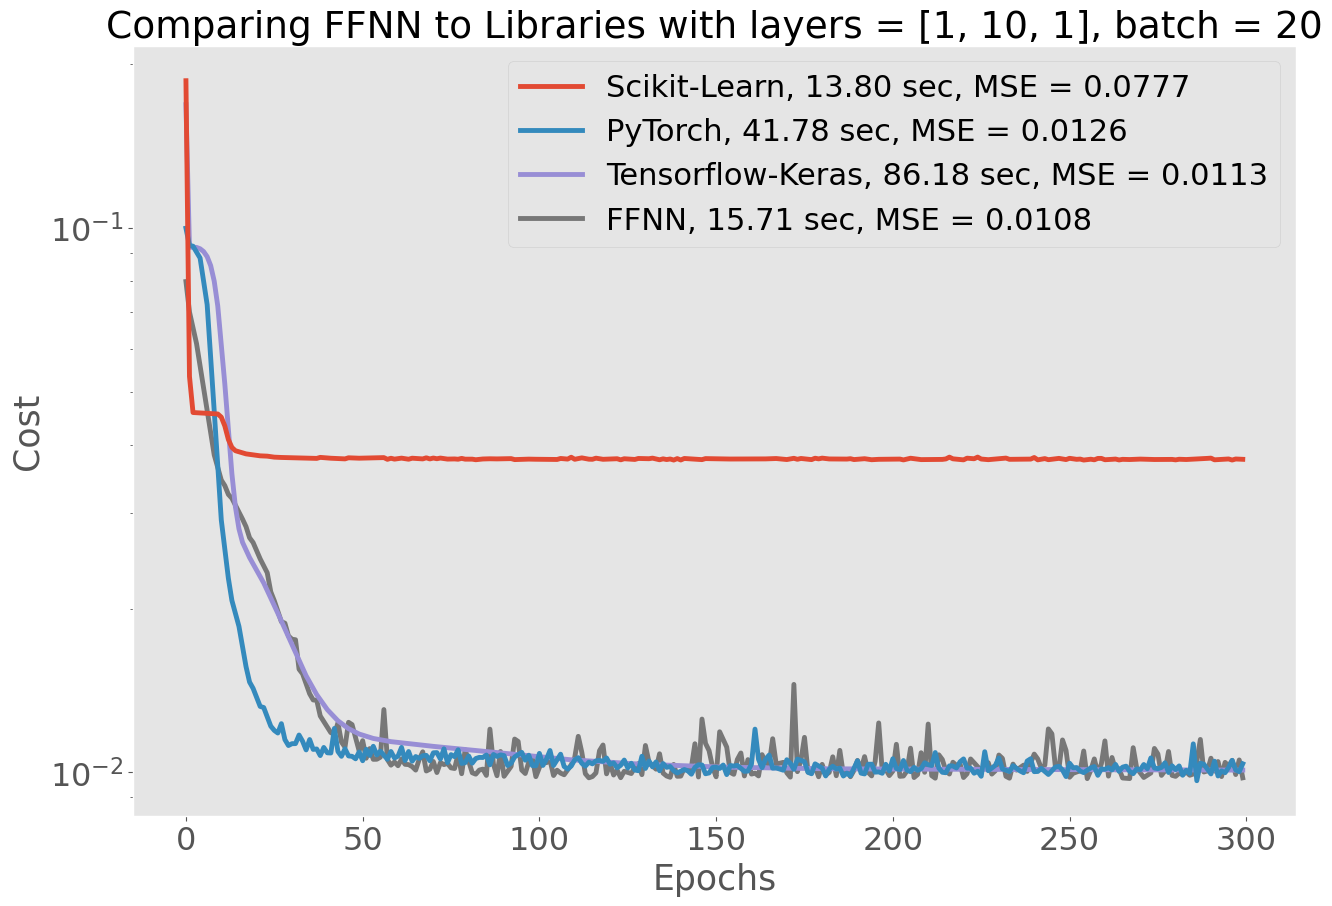

In [9]:
# Create a list of (MSE, plot data) tuples
plot_data = [
    (mse_pytorch, (loss_history, 'PyTorch', elapsed_time_pytorch)),
    (mse_proj2, (Regression_FFNN.get_info()["Cost_history"], 'FFNN', elapsed_time_FFNN)),
    (mse_sklearn, (sklearn_model.loss_curve_, 'Scikit-Learn', elapsed_time_scikit)),
    (mse_keras, (history.history['loss'], 'Tensorflow-Keras', elapsed_time_keras)),
]
# Sort the data by MSE in descending order
plot_data.sort(key=lambda x: x[0], reverse=True)
# Plot the data
plt.figure(figsize=(15,10))
for mse_plot, (data, label, elapsed_time) in plot_data:
    plt.plot(data, linewidth=3.5, linestyle='-', alpha=1, 
            label=f'{label}, {elapsed_time:.2f} sec, MSE = {mse_plot:.4f}', 
            zorder=mse_plot * 10000)  # Use MSE for zorder
plt.xlabel("Epochs", fontsize=25)
plt.ylabel("Cost", fontsize=25)
plt.yscale("log")
plt.title(f"Comparing FFNN to Libraries with layers = {nn1_pytorch_layers}, batch = {batch_size}", fontsize=27)
plt.legend(fontsize=22)
# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=23)
#plt.show()
plt.grid()
plt.savefig(out_dir / f"C_{mod_type}_cost{epochs}.pdf", dpi=200, bbox_inches="tight")

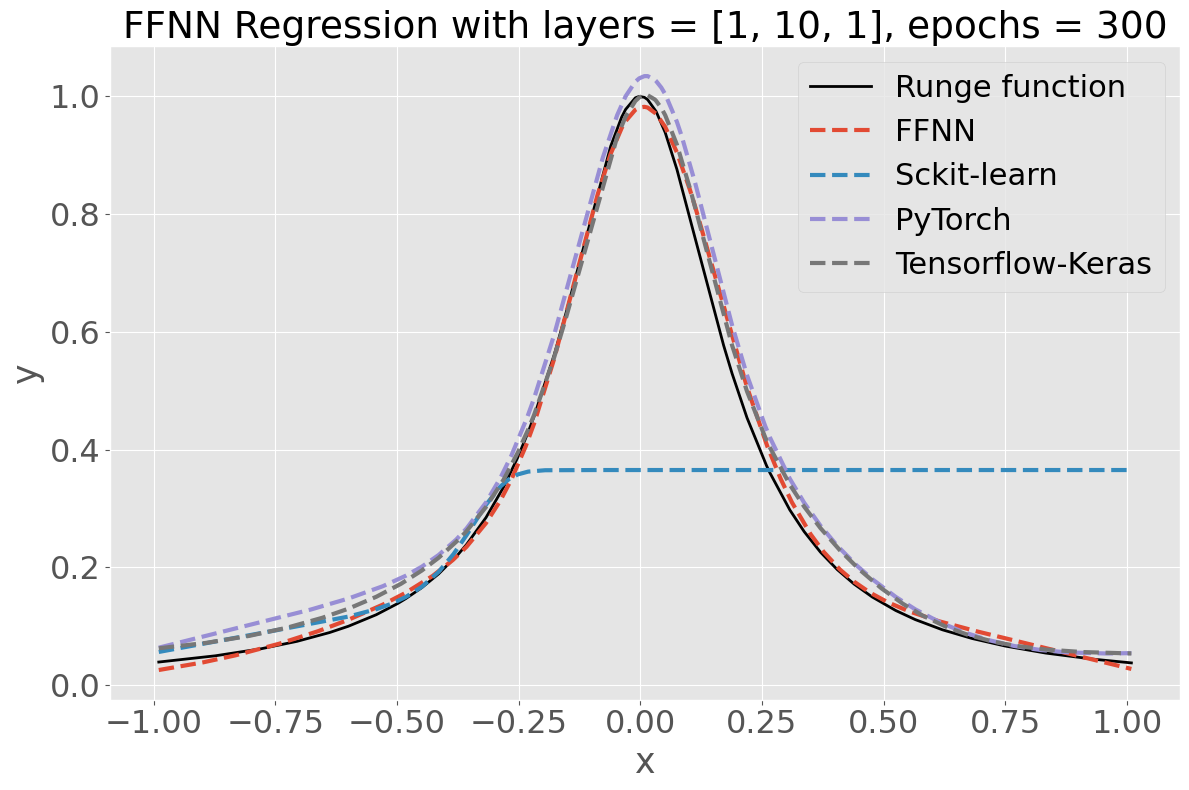

In [10]:
# Ensure x_test is a 1D array
x_test = x_test.flatten()  # Use .ravel() if you want to preserve a copy of the original array
# Sort the data
sorted_indices = np.argsort(x_test)
x_sorted = x_test[sorted_indices]
y_plot = runge_function(x_sorted)
# Flatten y predictions to 1D
y_sorted = {
    "1 layer NN": y_pred[sorted_indices].flatten(),
    "2 layer NN (sklearn)": y_pred_sklearn[sorted_indices].flatten(),
    "2 layer NN (PyTorch)": y_pred_pytorch[sorted_indices].flatten(),
    "2 layer NN (Keras)": y_pred_keras[sorted_indices].flatten(),
}
# Plotting
plt.figure(figsize=(12, 8))
plt.plot(x_sorted, y_plot, "-", c='k', linewidth=2, label=f"Runge function")
plt.plot(x_sorted, y_sorted["1 layer NN"], "--", linewidth=3, label=f"FFNN")#, MSE = {mse_proj2:.4f}")
plt.plot(x_sorted, y_sorted["2 layer NN (sklearn)"], "--", linewidth=3, label=f"Sckit-learn")#, MSE = {mse_sklearn:.4f}")
plt.plot(x_sorted, y_sorted["2 layer NN (PyTorch)"], "--", linewidth=3, label=f"PyTorch")#, MSE = {mse_pytorch:.4f}")
plt.plot(x_sorted, y_sorted["2 layer NN (Keras)"], "--", linewidth=3, label=f"Tensorflow-Keras")#, MSE = {mse_keras:.4f}")
plt.xlabel("x", fontsize=25)
plt.ylabel("y", fontsize=25)
plt.title(f"FFNN Regression with layers = {nn1_pytorch_layers}, epochs = {epochs}", fontsize=27)
# Move the legend outside of the plot
plt.legend(fontsize=22)#(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.tight_layout()  # Adjust layout to accommodate legend
#plt.show()
plt.savefig(out_dir / f"C_{mod_type}_cost{epochs}_runge.pdf", dpi=200, bbox_inches="tight")

##### B ) 1000 epochs, simple model :

In [8]:
epochs   = 1000
mod_type = 'simple'
print(' FFNN : ')
print()
Regression_FFNN, elapsed_time_FFNN, mse_proj2, y_pred = FFNN(network_input_size, 
                                                             nn1_FFNN_layers, 
                                                             nn1_FFNN_act_fun, 
                                                             nn1_FFNN_act_fun_der, 
                                                             FFNN_cost_fun, 
                                                             FFNN_cost_fun_der,
                                                             inputs, 
                                                             targets, 
                                                             epochs, 
                                                             learning_rate, 
                                                             batch_size, 
                                                             FFN_solver, 
                                                             shuffle, 
                                                             beta_1, 
                                                             beta_2, 
                                                             replacement, 
                                                             x_test, 
                                                             y_test)
print()
print(' Scikit-learn : ')
print()
sklearn_model, elapsed_time_scikit, mse_sklearn, y_pred_sklearn = scikitFFNN(nn1_scikit_layer, 
                                                                             nn1_scikit_act_fun, 
                                                                             scikit_solver, 
                                                                             scikit_alpha, 
                                                                             batch_size, 
                                                                             scikit_lr_type, 
                                                                             learning_rate,
                                                                             epochs, 
                                                                             shuffle, 
                                                                             seed, 
                                                                             tolerance, 
                                                                             scikit_verbose, 
                                                                             scikit_warm_start, 
                                                                             scikit_momentum, 
                                                                             scikit_nesterovs_momentum,
                                                                             early_stopping, 
                                                                             scikit_validation_fraction, 
                                                                             beta_1, 
                                                                             beta_2, 
                                                                             scikit_epsilon, 
                                                                             scikit_n_iter_no_change,
                                                                             inputs, 
                                                                             targets, 
                                                                             x_test, 
                                                                             y_test)
print()
print(' Tensorflow-Keras : ')
print()
history, elapsed_time_keras, mse_keras, y_pred_keras = kerasFFNN(nn1_keras_layers, 
                                                                 nn1_keras_act_fun, 
                                                                 network_input_size, 
                                                                 keras_cost_fun, 
                                                                 keras_solver, 
                                                                 inputs, 
                                                                 targets, 
                                                                 epochs, 
                                                                 batch_size, 
                                                                 keras_verbose, 
                                                                 shuffle, 
                                                                 x_test, 
                                                                 y_test)
print()
print(' PyTorch : ')
print()
model, elapsed_time_pytorch, loss_history, mse_pytorch, y_pred_pytorch = pytorchFFNN(nn1_pytorch_layers, 
                                                                                     inputs, 
                                                                                     targets, 
                                                                                     batch_size, 
                                                                                     shuffle, 
                                                                                     learning_rate, 
                                                                                     epochs,
                                                                                     x_test, 
                                                                                     y_test)
print()

 FFNN : 

Project-2 MSE: 0.0104798156117574
Project-2 MSE: 0.0104798156117574
Elapsed time: 25.84 seconds

 Scikit-learn : 



c:\Users\Ingvild\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Ingvild\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Scikit-Learn MSE: 0.010833042079082901
Scikit-Learn MSE: 0.010833042079082901
Elapsed time: 35.85 seconds

 Tensorflow-Keras : 

Tensorflow-Keras MSE: 0.011300036465647445
Tensorflow-Keras MSE: 0.011300036465647445
Elapsed time: 294.00 seconds

 PyTorch : 

PyTorch MSE: 0.011164937264959717
PyTorch MSE: 0.011164937264959717
Elapsed time: 110.52 seconds



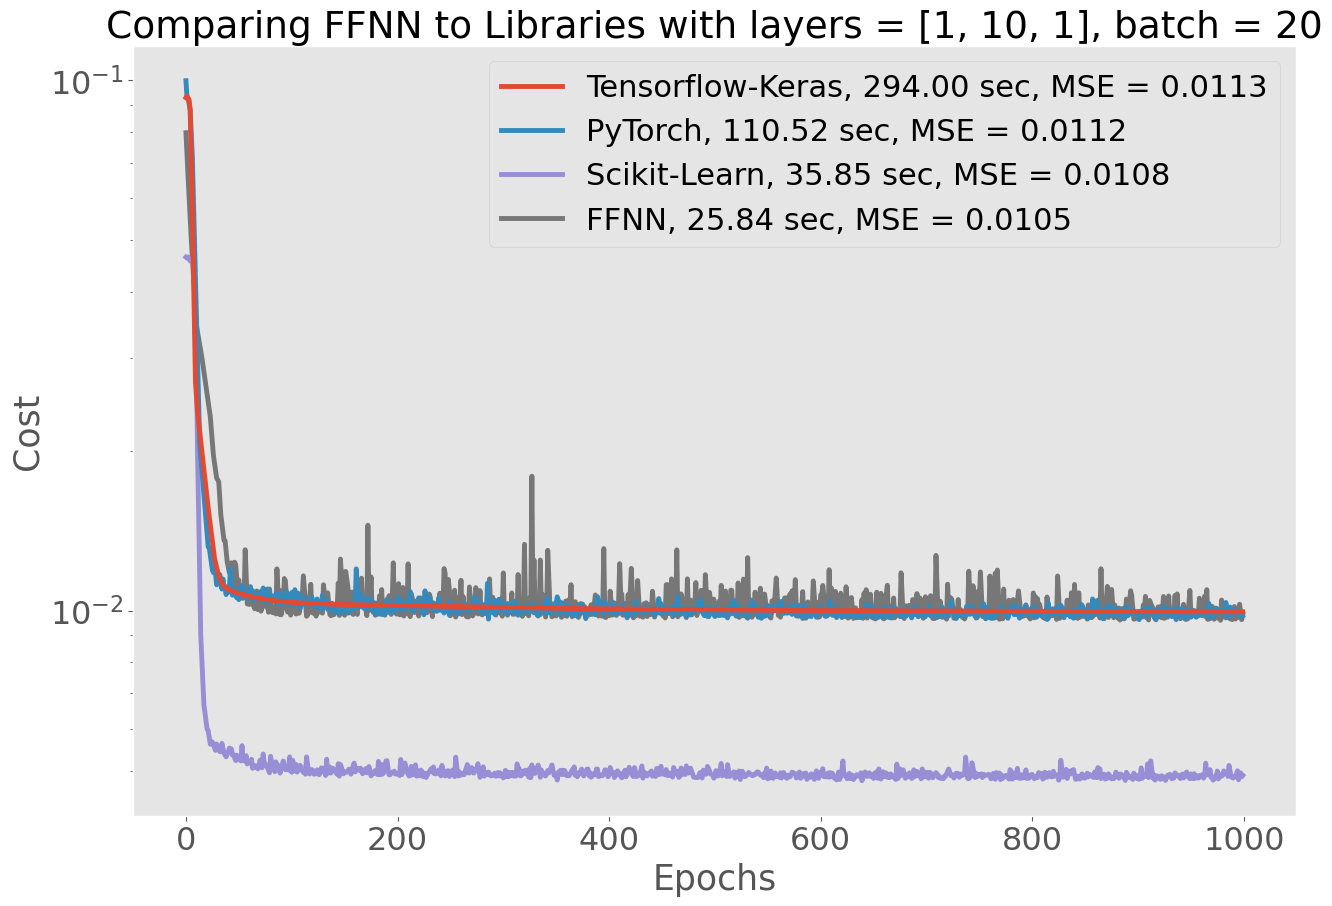

In [9]:
# Create a list of (MSE, plot data) tuples
plot_data = [
    (mse_pytorch, (loss_history, 'PyTorch', elapsed_time_pytorch)),
    (mse_proj2, (Regression_FFNN.get_info()["Cost_history"], 'FFNN', elapsed_time_FFNN)),
    (mse_sklearn, (sklearn_model.loss_curve_, 'Scikit-Learn', elapsed_time_scikit)),
    (mse_keras, (history.history['loss'], 'Tensorflow-Keras', elapsed_time_keras)),
]
# Sort the data by MSE in descending order
plot_data.sort(key=lambda x: x[0], reverse=True)
# Plot the data
plt.figure(figsize=(15,10))
for mse_plot, (data, label, elapsed_time) in plot_data:
    plt.plot(data, linewidth=3.5, linestyle='-', alpha=1, 
            label=f'{label}, {elapsed_time:.2f} sec, MSE = {mse_plot:.4f}', 
            zorder=mse_plot * 10000)  # Use MSE for zorder
plt.xlabel("Epochs", fontsize=25)
plt.ylabel("Cost", fontsize=25)
plt.yscale("log")
plt.title(f"Comparing FFNN to Libraries with layers = {nn1_pytorch_layers}, batch = {batch_size}", fontsize=27)
plt.legend(fontsize=22)
# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=23)
#plt.show()
plt.grid()
plt.savefig(out_dir / f"C_{mod_type}_cost{epochs}.pdf", dpi=200, bbox_inches="tight")

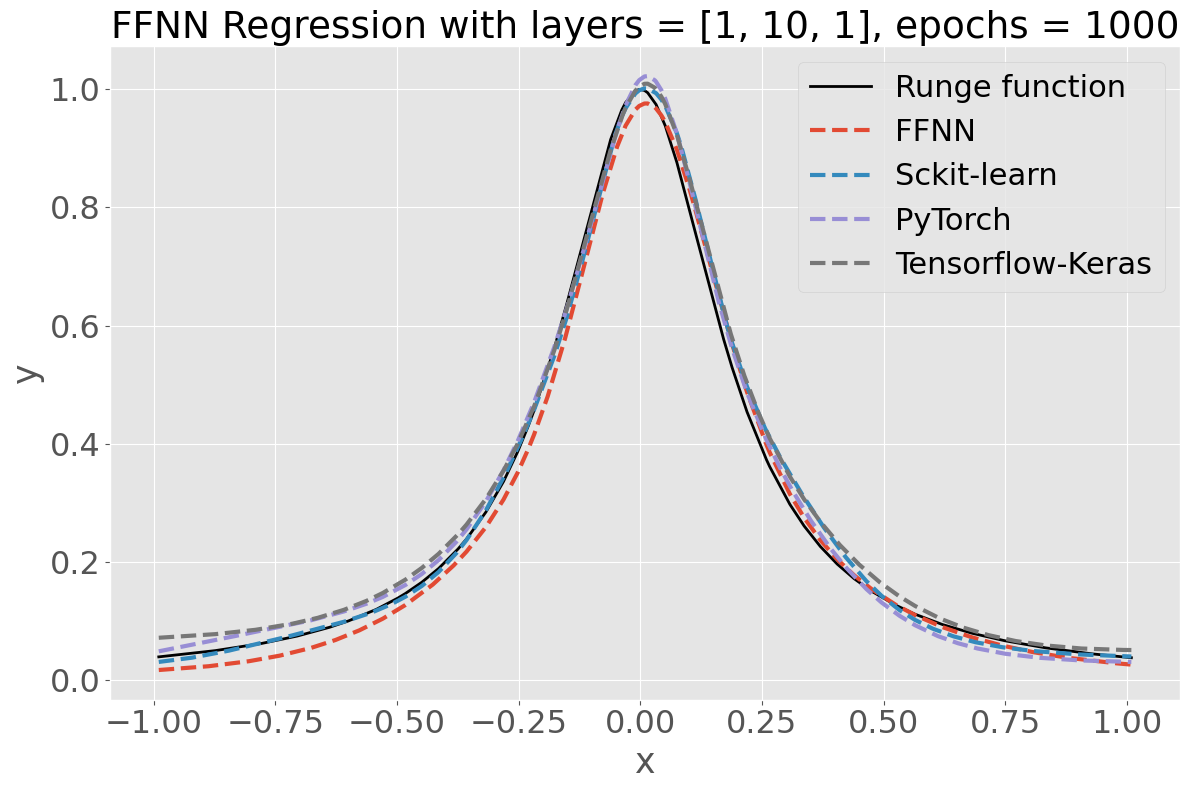

In [10]:
# Ensure x_test is a 1D array
x_test = x_test.flatten()  # Use .ravel() if you want to preserve a copy of the original array
# Sort the data
sorted_indices = np.argsort(x_test)
x_sorted = x_test[sorted_indices]
y_plot = runge_function(x_sorted)
# Flatten y predictions to 1D
y_sorted = {
    "1 layer NN": y_pred[sorted_indices].flatten(),
    "2 layer NN (sklearn)": y_pred_sklearn[sorted_indices].flatten(),
    "2 layer NN (PyTorch)": y_pred_pytorch[sorted_indices].flatten(),
    "2 layer NN (Keras)": y_pred_keras[sorted_indices].flatten(),
}
# Plotting
plt.figure(figsize=(12, 8))
plt.plot(x_sorted, y_plot, "-", c='k', linewidth=2, label=f"Runge function")
plt.plot(x_sorted, y_sorted["1 layer NN"], "--", linewidth=3, label=f"FFNN")#, MSE = {mse_proj2:.4f}")
plt.plot(x_sorted, y_sorted["2 layer NN (sklearn)"], "--", linewidth=3, label=f"Sckit-learn")#, MSE = {mse_sklearn:.4f}")
plt.plot(x_sorted, y_sorted["2 layer NN (PyTorch)"], "--", linewidth=3, label=f"PyTorch")#, MSE = {mse_pytorch:.4f}")
plt.plot(x_sorted, y_sorted["2 layer NN (Keras)"], "--", linewidth=3, label=f"Tensorflow-Keras")#, MSE = {mse_keras:.4f}")
plt.xlabel("x", fontsize=25)
plt.ylabel("y", fontsize=25)
plt.title(f"FFNN Regression with layers = {nn1_pytorch_layers}, epochs = {epochs}", fontsize=27)
# Move the legend outside of the plot
plt.legend(fontsize=22)#(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.tight_layout()  # Adjust layout to accommodate legend
#plt.show()
plt.savefig(out_dir / f"C_{mod_type}_cost{epochs}_runge.pdf", dpi=200, bbox_inches="tight")

##### C ) 300 epochs, complex model :

In [8]:
epochs   = 300
mod_type = 'complex'
print(' FFNN : ')
print()
Regression_FFNN, elapsed_time_FFNN, mse_proj2, y_pred = FFNN(network_input_size, 
                                                             nn2_FFNN_layers, 
                                                             nn2_FFNN_act_fun, 
                                                             nn2_FFNN_act_fun_der, 
                                                             FFNN_cost_fun, 
                                                             FFNN_cost_fun_der,
                                                             inputs, 
                                                             targets, 
                                                             epochs, 
                                                             learning_rate, 
                                                             batch_size, 
                                                             FFN_solver, 
                                                             shuffle, 
                                                             beta_1, 
                                                             beta_2, 
                                                             replacement, 
                                                             x_test, 
                                                             y_test)
print()
print(' Scikit-learn : ')
print()
sklearn_model, elapsed_time_scikit, mse_sklearn, y_pred_sklearn = scikitFFNN(nn2_scikit_layer, 
                                                                             nn2_scikit_act_fun, 
                                                                             scikit_solver, 
                                                                             scikit_alpha, 
                                                                             batch_size, 
                                                                             scikit_lr_type, 
                                                                             learning_rate,
                                                                             epochs, 
                                                                             shuffle, 
                                                                             seed, 
                                                                             tolerance, 
                                                                             scikit_verbose, 
                                                                             scikit_warm_start, 
                                                                             scikit_momentum, 
                                                                             scikit_nesterovs_momentum,
                                                                             early_stopping, 
                                                                             scikit_validation_fraction, 
                                                                             beta_1, 
                                                                             beta_2, 
                                                                             scikit_epsilon, 
                                                                             scikit_n_iter_no_change,
                                                                             inputs, 
                                                                             targets, 
                                                                             x_test, 
                                                                             y_test)
print()
print(' Tensorflow-Keras : ')
print()
history, elapsed_time_keras, mse_keras, y_pred_keras = kerasFFNN(nn2_keras_layers, 
                                                                 nn2_keras_act_fun, 
                                                                 network_input_size, 
                                                                 keras_cost_fun, 
                                                                 keras_solver, 
                                                                 inputs, 
                                                                 targets, 
                                                                 epochs, 
                                                                 batch_size, 
                                                                 keras_verbose, 
                                                                 shuffle, 
                                                                 x_test, 
                                                                 y_test)
print()
print(' PyTorch : ')
print()
model, elapsed_time_pytorch, loss_history, mse_pytorch, y_pred_pytorch = pytorchFFNN(nn2_pytorch_layers, 
                                                                                     inputs, 
                                                                                     targets, 
                                                                                     batch_size, 
                                                                                     shuffle, 
                                                                                     learning_rate, 
                                                                                     epochs,
                                                                                     x_test, 
                                                                                     y_test)
print()

 FFNN : 

Project-2 MSE: 0.011113167436554489
Project-2 MSE: 0.011113167436554489
Elapsed time: 30.23 seconds

 Scikit-learn : 



c:\Users\Ingvild\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Ingvild\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Scikit-Learn MSE: 0.011286760213195005
Scikit-Learn MSE: 0.011286760213195005
Elapsed time: 30.43 seconds

 Tensorflow-Keras : 

Tensorflow-Keras MSE: 0.011609235019704622
Tensorflow-Keras MSE: 0.011609235019704622
Elapsed time: 93.79 seconds

 PyTorch : 

PyTorch MSE: 0.011114181738454488
PyTorch MSE: 0.011114181738454488
Elapsed time: 78.93 seconds



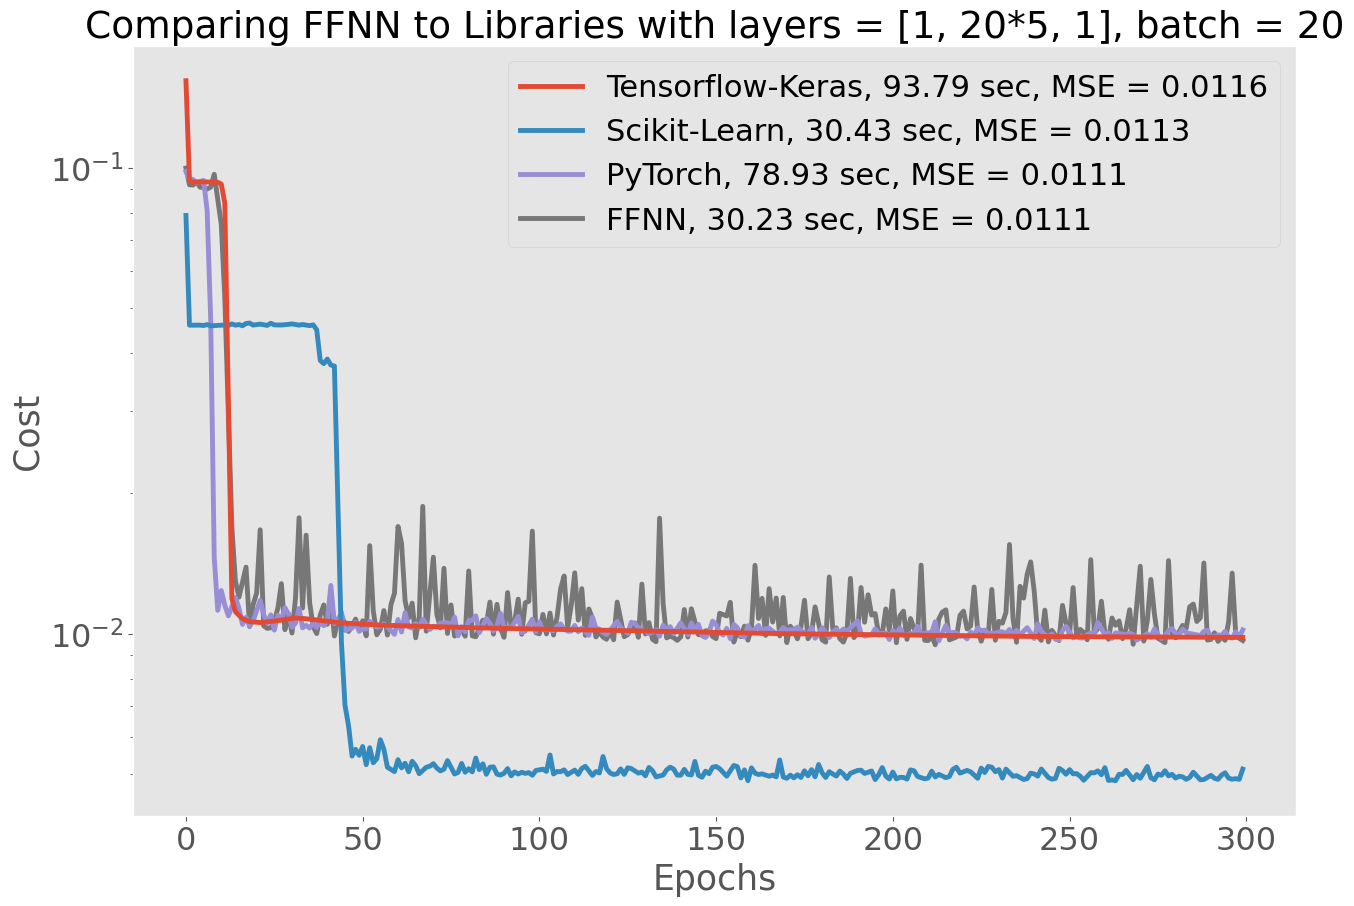

In [9]:
# Create a list of (MSE, plot data) tuples
plot_data = [
    (mse_pytorch, (loss_history, 'PyTorch', elapsed_time_pytorch)),
    (mse_proj2, (Regression_FFNN.get_info()["Cost_history"], 'FFNN', elapsed_time_FFNN)),
    (mse_sklearn, (sklearn_model.loss_curve_, 'Scikit-Learn', elapsed_time_scikit)),
    (mse_keras, (history.history['loss'], 'Tensorflow-Keras', elapsed_time_keras)),
]
# Sort the data by MSE in descending order
plot_data.sort(key=lambda x: x[0], reverse=True)
# Plot the data
plt.figure(figsize=(15,10))
for mse_plot, (data, label, elapsed_time) in plot_data:
    plt.plot(data, linewidth=3.5, linestyle='-', alpha=1, 
            label=f'{label}, {elapsed_time:.2f} sec, MSE = {mse_plot:.4f}', 
            zorder=mse_plot * 10000)  # Use MSE for zorder
plt.xlabel("Epochs", fontsize=25)
plt.ylabel("Cost", fontsize=25)
plt.yscale("log")
plt.title(f"Comparing FFNN to Libraries with layers = {nn2_layers_str}, batch = {batch_size}", fontsize=27)
plt.legend(fontsize=22)
# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=23)
#plt.show()
plt.grid()
plt.savefig(out_dir / f"C_{mod_type}_cost{epochs}.pdf", dpi=200, bbox_inches="tight")

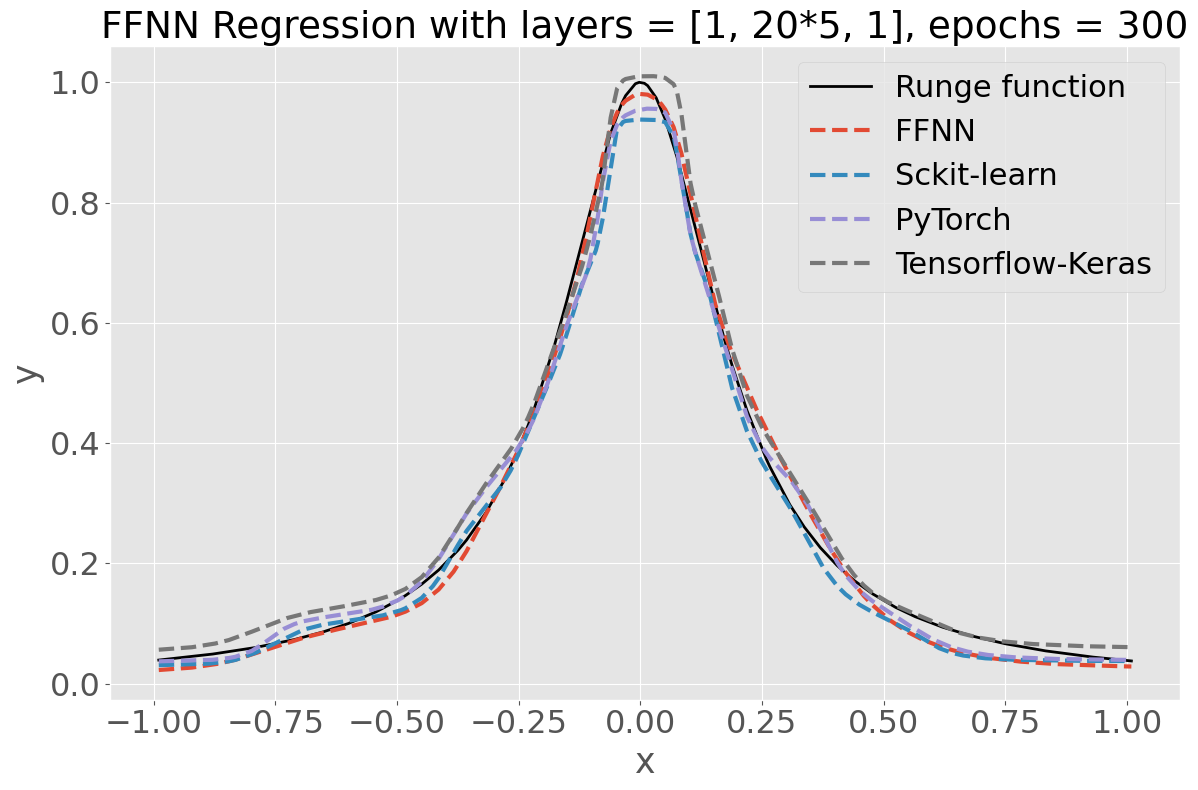

In [10]:
# Ensure x_test is a 1D array
x_test = x_test.flatten()  # Use .ravel() if you want to preserve a copy of the original array
# Sort the data
sorted_indices = np.argsort(x_test)
x_sorted = x_test[sorted_indices]
y_plot = runge_function(x_sorted)
# Flatten y predictions to 1D
y_sorted = {
    "1 layer NN": y_pred[sorted_indices].flatten(),
    "2 layer NN (sklearn)": y_pred_sklearn[sorted_indices].flatten(),
    "2 layer NN (PyTorch)": y_pred_pytorch[sorted_indices].flatten(),
    "2 layer NN (Keras)": y_pred_keras[sorted_indices].flatten(),
}
# Plotting
plt.figure(figsize=(12, 8))
plt.plot(x_sorted, y_plot, "-", c='k', linewidth=2, label=f"Runge function")
plt.plot(x_sorted, y_sorted["1 layer NN"], "--", linewidth=3, label=f"FFNN")#, MSE = {mse_proj2:.4f}")
plt.plot(x_sorted, y_sorted["2 layer NN (sklearn)"], "--", linewidth=3, label=f"Sckit-learn")#, MSE = {mse_sklearn:.4f}")
plt.plot(x_sorted, y_sorted["2 layer NN (PyTorch)"], "--", linewidth=3, label=f"PyTorch")#, MSE = {mse_pytorch:.4f}")
plt.plot(x_sorted, y_sorted["2 layer NN (Keras)"], "--", linewidth=3, label=f"Tensorflow-Keras")#, MSE = {mse_keras:.4f}")
plt.xlabel("x", fontsize=25)
plt.ylabel("y", fontsize=25)
plt.title(f"FFNN Regression with layers = {nn2_layers_str}, epochs = {epochs}", fontsize=27)
# Move the legend outside of the plot
plt.legend(fontsize=22)#(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.tight_layout()  # Adjust layout to accommodate legend
#plt.show()
plt.savefig(out_dir / f"C_{mod_type}_cost{epochs}_runge.pdf", dpi=200, bbox_inches="tight")

##### D ) 1000 epochs, complex model :

In [8]:
epochs   = 1000
mod_type = 'complex'
print(' FFNN : ')
print()
Regression_FFNN, elapsed_time_FFNN, mse_proj2, y_pred = FFNN(network_input_size, 
                                                             nn2_FFNN_layers, 
                                                             nn2_FFNN_act_fun, 
                                                             nn2_FFNN_act_fun_der, 
                                                             FFNN_cost_fun, 
                                                             FFNN_cost_fun_der,
                                                             inputs, 
                                                             targets, 
                                                             epochs, 
                                                             learning_rate, 
                                                             batch_size, 
                                                             FFN_solver, 
                                                             shuffle, 
                                                             beta_1, 
                                                             beta_2, 
                                                             replacement, 
                                                             x_test, 
                                                             y_test)
print()
print(' Scikit-learn : ')
print()
sklearn_model, elapsed_time_scikit, mse_sklearn, y_pred_sklearn = scikitFFNN(nn2_scikit_layer, 
                                                                             nn2_scikit_act_fun, 
                                                                             scikit_solver, 
                                                                             scikit_alpha, 
                                                                             batch_size, 
                                                                             scikit_lr_type, 
                                                                             learning_rate,
                                                                             epochs, 
                                                                             shuffle, 
                                                                             seed, 
                                                                             tolerance, 
                                                                             scikit_verbose, 
                                                                             scikit_warm_start, 
                                                                             scikit_momentum, 
                                                                             scikit_nesterovs_momentum,
                                                                             early_stopping, 
                                                                             scikit_validation_fraction, 
                                                                             beta_1, 
                                                                             beta_2, 
                                                                             scikit_epsilon, 
                                                                             scikit_n_iter_no_change,
                                                                             inputs, 
                                                                             targets, 
                                                                             x_test, 
                                                                             y_test)
print()
print(' Tensorflow-Keras : ')
print()
history, elapsed_time_keras, mse_keras, y_pred_keras = kerasFFNN(nn2_keras_layers, 
                                                                 nn2_keras_act_fun, 
                                                                 network_input_size, 
                                                                 keras_cost_fun, 
                                                                 keras_solver, 
                                                                 inputs, 
                                                                 targets, 
                                                                 epochs, 
                                                                 batch_size, 
                                                                 keras_verbose, 
                                                                 shuffle, 
                                                                 x_test, 
                                                                 y_test)
print()
print(' PyTorch : ')
print()
model, elapsed_time_pytorch, loss_history, mse_pytorch, y_pred_pytorch = pytorchFFNN(nn2_pytorch_layers, 
                                                                                     inputs, 
                                                                                     targets, 
                                                                                     batch_size, 
                                                                                     shuffle, 
                                                                                     learning_rate, 
                                                                                     epochs,
                                                                                     x_test, 
                                                                                     y_test)
print()

 FFNN : 

Project-2 MSE: 0.012615739312059893
Project-2 MSE: 0.012615739312059893
Elapsed time: 116.85 seconds

 Scikit-learn : 



c:\Users\Ingvild\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Ingvild\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Scikit-Learn MSE: 0.011024725568844783
Scikit-Learn MSE: 0.011024725568844783
Elapsed time: 98.04 seconds

 Tensorflow-Keras : 

Tensorflow-Keras MSE: 0.01118311888072679
Tensorflow-Keras MSE: 0.01118311888072679
Elapsed time: 307.40 seconds

 PyTorch : 

PyTorch MSE: 0.011353690495697037
PyTorch MSE: 0.011353690495697037
Elapsed time: 258.71 seconds



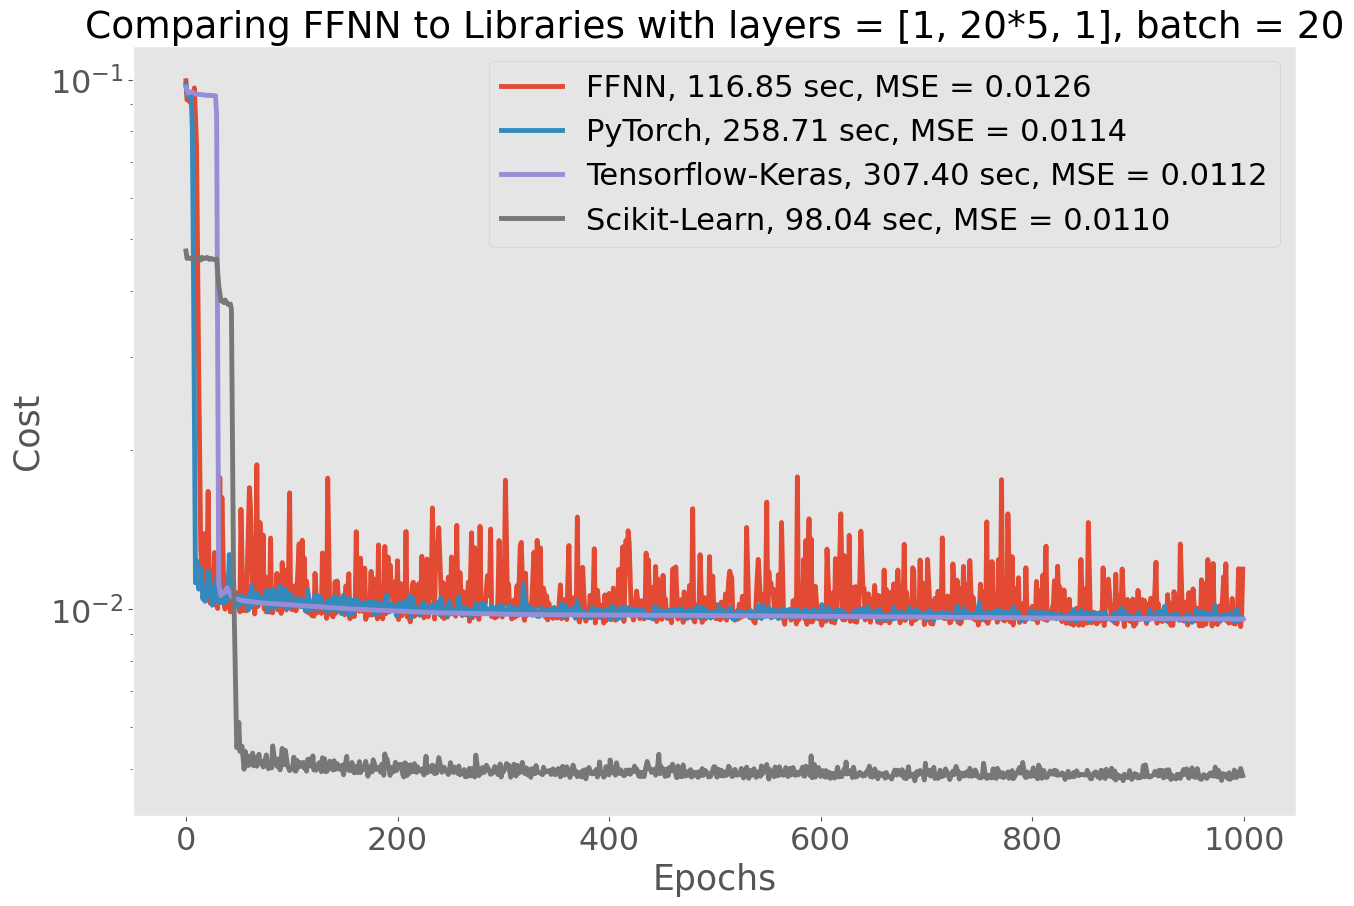

In [9]:
# Create a list of (MSE, plot data) tuples
plot_data = [
    (mse_pytorch, (loss_history, 'PyTorch', elapsed_time_pytorch)),
    (mse_proj2, (Regression_FFNN.get_info()["Cost_history"], 'FFNN', elapsed_time_FFNN)),
    (mse_sklearn, (sklearn_model.loss_curve_, 'Scikit-Learn', elapsed_time_scikit)),
    (mse_keras, (history.history['loss'], 'Tensorflow-Keras', elapsed_time_keras)),
]
# Sort the data by MSE in descending order
plot_data.sort(key=lambda x: x[0], reverse=True)
# Plot the data
plt.figure(figsize=(15,10))
for mse_plot, (data, label, elapsed_time) in plot_data:
    plt.plot(data, linewidth=3.5, linestyle='-', alpha=1, 
            label=f'{label}, {elapsed_time:.2f} sec, MSE = {mse_plot:.4f}', 
            zorder=-mse_plot * 1000)  # Use MSE for zorder
plt.xlabel("Epochs", fontsize=25)
plt.ylabel("Cost", fontsize=25)
plt.yscale("log")
plt.title(f"Comparing FFNN to Libraries with layers = {nn2_layers_str}, batch = {batch_size}", fontsize=27)
plt.legend(fontsize=22)
# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=23)
#plt.show()
plt.grid()
plt.savefig(out_dir / f"C_{mod_type}_cost{epochs}.pdf", dpi=200, bbox_inches="tight")

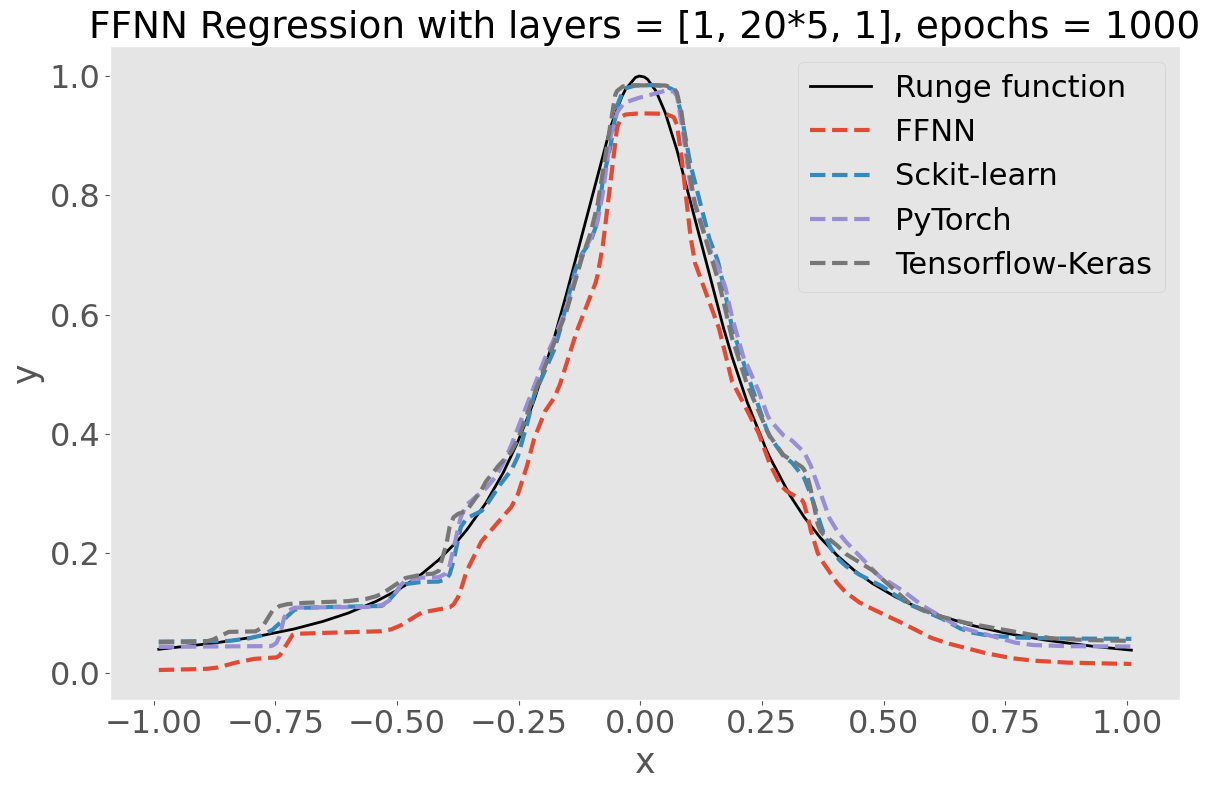

In [10]:
# Ensure x_test is a 1D array
x_test = x_test.flatten()  # Use .ravel() if you want to preserve a copy of the original array
# Sort the data
sorted_indices = np.argsort(x_test)
x_sorted = x_test[sorted_indices]
y_plot = runge_function(x_sorted)
# Flatten y predictions to 1D
y_sorted = {
    "1 layer NN": y_pred[sorted_indices].flatten(),
    "2 layer NN (sklearn)": y_pred_sklearn[sorted_indices].flatten(),
    "2 layer NN (PyTorch)": y_pred_pytorch[sorted_indices].flatten(),
    "2 layer NN (Keras)": y_pred_keras[sorted_indices].flatten(),
}
# Plotting
plt.figure(figsize=(12, 8))
plt.plot(x_sorted, y_plot, "-", c='k', linewidth=2, label=f"Runge function")
plt.plot(x_sorted, y_sorted["1 layer NN"], "--", linewidth=3, label=f"FFNN")#, MSE = {mse_proj2:.4f}")
plt.plot(x_sorted, y_sorted["2 layer NN (sklearn)"], "--", linewidth=3, label=f"Sckit-learn")#, MSE = {mse_sklearn:.4f}")
plt.plot(x_sorted, y_sorted["2 layer NN (PyTorch)"], "--", linewidth=3, label=f"PyTorch")#, MSE = {mse_pytorch:.4f}")
plt.plot(x_sorted, y_sorted["2 layer NN (Keras)"], "--", linewidth=3, label=f"Tensorflow-Keras")#, MSE = {mse_keras:.4f}")
plt.xlabel("x", fontsize=25)
plt.ylabel("y", fontsize=25)
plt.title(f"FFNN Regression with layers = {nn2_layers_str}, epochs = {epochs}", fontsize=27)
# Move the legend outside of the plot
plt.legend(fontsize=22)#(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.tight_layout()  # Adjust layout to accommodate legend
#plt.show()
plt.grid()
plt.savefig(out_dir / f"C_{mod_type}_cost{epochs}_runge.pdf", dpi=200, bbox_inches="tight")

##### 2) Test against Autograd or 

Also test that your derivatives are correctly
calculated using automatic differentiation, using for example the
**Autograd** library or the **JAX** library. It is optional to implement
these libraries for the present project. In this project they serve as
useful tests of our derivatives.

In [14]:
import autograd.numpy as np
from autograd import grad

# Define the cost function for a one-layer neural network
def cost_one_layer(W, b, x, target):
    z = np.dot(W, x) + b
    a = 1.0 / (1 + np.exp(-z))  # Sigmoid activation
    return np.mean((a - target) ** 2)  # Mean squared error

# Mean Squared Error derivative
def mse_der(predict, target):
    target = target.reshape(-1)  # Ensure target is a 1D array
    assert predict.shape == target.shape, "Not same"
    return 2 * (predict - target) / target.size

# Sigmoid activation function
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

# Derivative of sigmoid function
def sigmoid_der(z):
    sig = sigmoid(z)
    return sig * (1 - sig)

# Random input and target for testing
x = np.random.rand(2)
target = np.random.rand(3)

# Random weights and bias
W = np.random.rand(3, 2)
b = np.random.rand(3)

# Calculate gradients using autograd
autograd_one_layer = grad(cost_one_layer, [0, 1])

# Compute the activations and predictions
z = W @ x + b
a = sigmoid(z)
predict = a

# Calculate the derivatives for backpropagation
dC_da = mse_der(predict.reshape(-1), target)  # Ensure same shape

da_dz = sigmoid_der(z)

dC_dz = dC_da * da_dz

dC_dW = np.outer(dC_dz, x)  # Gradient wrt weights

dC_db = dC_dz  # Gradient wrt biases

# Print the computed gradients and derivatives
print("\n--- Backpropagation Derivatives ---")
print(f"Weight Gradient (dC/dW):\n{dC_dW}\n")
print(f"Bias Gradient (dC/db):\n{dC_db}\n")

# Compute the gradients using autograd
W_g, b_g = autograd_one_layer(W, b, x, target)

# Print autograd gradients
print("--- Autograd Gradients ---")
print(f"Weight Gradient from Autograd (dC/dW):\n{W_g}\n")
print(f"Bias Gradient from Autograd (dC/db):\n{b_g}\n")

# Optional: compare the results to see if they're similar
print("--- Comparison of Gradients ---")
print(f"Difference in Weight Gradients:\n{W_g - dC_dW}\n")
print(f"Difference in Bias Gradients:\n{b_g - dC_db}\n")



--- Backpropagation Derivatives ---
Weight Gradient (dC/dW):
[[0.00190526 0.00277343]
 [0.02960511 0.0430953 ]
 [0.04200477 0.06114511]]

Bias Gradient (dC/db):
[0.00279411 0.04341664 0.06160105]

--- Autograd Gradients ---
Weight Gradient from Autograd (dC/dW):
[[0.00190526 0.00277343]
 [0.02960511 0.0430953 ]
 [0.04200477 0.06114511]]

Bias Gradient from Autograd (dC/db):
[0.00279411 0.04341664 0.06160105]

--- Comparison of Gradients ---
Difference in Weight Gradients:
[[-4.33680869e-19 -8.67361738e-19]
 [-1.04083409e-17 -1.38777878e-17]
 [ 2.77555756e-17  4.85722573e-17]]

Difference in Bias Gradients:
[-8.67361738e-19 -1.38777878e-17  4.85722573e-17]

